## Ungraded Lab: Fashion MNIST CNN Autoencoder

You will now work on an autoencoder that works on the [MNIST dataset](https://www.tensorflow.org/datasets/catalog/mnist). This will encode the inputs to lower resolution images. The decoder should then be able to generate the original input from this compressed representation.

In [1]:
# use Python 3.12
!pip install tensorflow_datasets

## Imports

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

## Prepare the Dataset

You will load the MNIST data from TFDS into train and test sets. Let's first define a preprocessing function for normalizing and flattening the images. Since we'll be training an autoencoder, this will return `image, image` because the input will also be the target or label while training.


In [3]:
def map_image(image, label):
  '''Normalizes and flattens the image. Returns image as input and label.'''
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0
  image = tf.reshape(image, shape=(28,28,1))# change dimension

  return image, image

In [4]:
# Load the train and test sets from TFDS

BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('fashion_mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('fashion_mnist', as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to C:\Users\tulas\tensorflow_datasets\fashion_mnist\3.0.1.incompleteDLZ4DJ\fashion_mnist-train.tfrecord


  0%|          | 0/60000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to C:\Users\tulas\tensorflow_datasets\fashion_mnist\3.0.1.incompleteDLZ4DJ\fashion_mnist-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to C:\Users\tulas\tensorflow_datasets\fashion_mnist\3.0.1. Subsequent calls will reuse this data.


## Build the Model

You will now build a simple autoencoder to ingest the data. Like before, the encoder will compress the input and reconstructs it in the decoder output. ![Autoencoder Flowchart](auto.png)

In [5]:
# Define the encoder function
def encoder(inputs):
    conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(inputs)
    max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1)
    conv_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(max_pool_1)
    max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)
    return max_pool_2

# Define the bottleneck function
def bottle_neck(inputs):
    bottle_neck = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(inputs)
    encoder_visualization = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(bottle_neck)
    return bottle_neck, encoder_visualization

# Define the decoder function
def decoder(inputs):
    conv_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(inputs)
    up_sample_1 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_1)
    conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(up_sample_1)
    up_sample_2 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_2)
    conv_3 = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(up_sample_2)
    return conv_3

# Define the full convolutional autoencoder model
def convolutional_auto_encoder():
    inputs = tf.keras.layers.Input(shape=(28, 28, 1))

    encoder_output = encoder(inputs)
    bottleneck_output, encoder_visualization = bottle_neck(encoder_output)
    decoder_output = decoder(bottleneck_output)

    # Define the complete autoencoder model
    model = tf.keras.Model(inputs=inputs, outputs=decoder_output)
    
    # Define the encoder visualization model
    encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_visualization)
    
    return model, encoder_model


In [6]:
convolutional_model, convolution_encoder_model = convolutional_auto_encoder()
convolutional_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 128)           │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 739,073 (2.82 MB)

 Trainable params: 739,073 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

## Compile the Model

You will setup the model for training. You can use binary crossentropy to measure the loss between pixel values that range from 0 (black) to 1 (white).

In [7]:
# Compile the model using Adam Optimizer , binary_crossentropy and  metrics=['accuracy']
autoencoder=convolutional_model
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(),loss="binary_crossentropy")

## Train the Model

In [8]:
# train the model using train_dataset,steps_per_epoch=step,epochs=10
step=60000//BATCH_SIZE
his=autoencoder.fit(train_dataset,steps_per_epoch=step,epochs=5)

Epoch 1/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 78s 161ms/step - loss: 0.3305
Epoch 2/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 80s 171ms/step - loss: 0.2619
Epoch 3/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 87s 186ms/step - loss: 0.2564
Epoch 4/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 90s 193ms/step - loss: 0.2537
Epoch 5/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 92s 197ms/step - loss: 0.2518


## Display sample results

You can now visualize the results. The utility functions below will help in plotting the encoded and decoded values.

Text(0, 0.5, 'Loss')

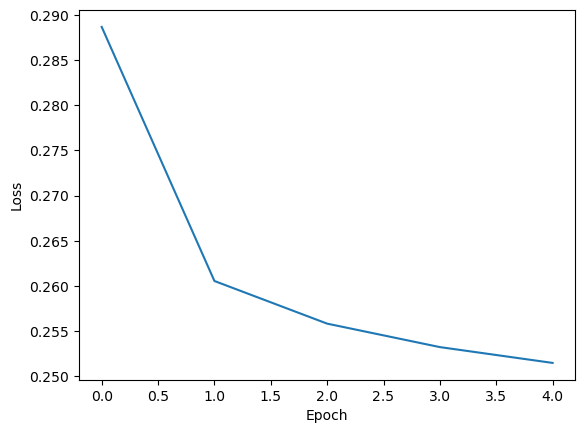

In [9]:
# This variable stores the outputs of the model comiplation 
plt.plot(his.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [10]:
def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Display sample outputs in one row.'''
  for idx, test_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
  '''Displays the input, encoded, and decoded output values.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(28,28,1))
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20, shape=(28,28,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


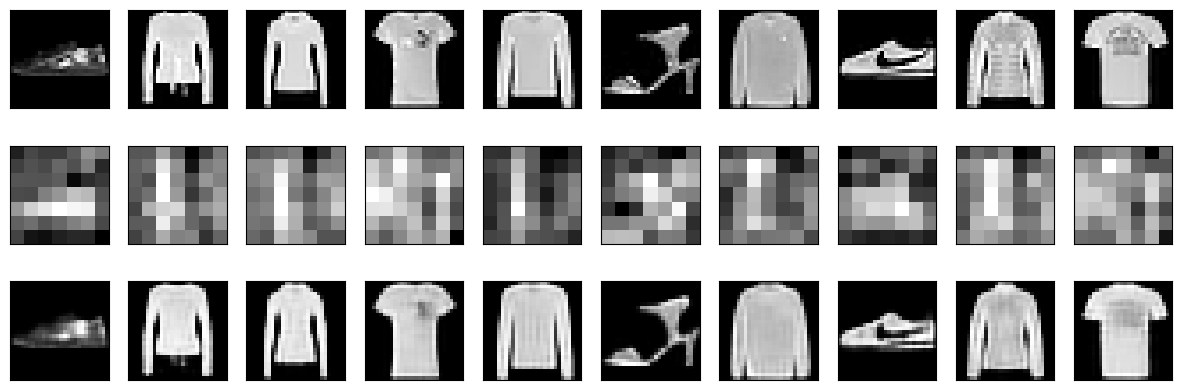

In [11]:
# take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# pick 10 random numbers to be used as indices to the list above
idxs = np.random.choice(BATCH_SIZE, size=10)

# get the encoder output
encoded_predicted = convolution_encoder_model.predict(test_dataset)

# get a prediction for the test batch
simple_predicted = autoencoder.predict(test_dataset)

# display the 10 samples, encodings and decoded values!
display_results(output_samples[idxs], encoded_predicted[idxs], simple_predicted[idxs],enc_shape=(7,7)) #added enc_shape